# Set up

In [1]:
from google.colab import drive

drive.mount('/content/drive')
drive_path = 'drive/MyDrive'

Mounted at /content/drive


Link to the original dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset

In [2]:
!unzip -qq 'drive/MyDrive/Sign-Language-Digits-Dataset.zip'
!unzip -qq 'drive/MyDrive/Sign-Language-Digits-Examples.zip'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, ReLU
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
#Image preprocessing
from keras.layers import Rescaling, Resizing
#Image augmentation
from keras.layers import RandomFlip, RandomRotation, RandomZoom

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Creating NumPy datasets

In [4]:
labels = [
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five',
    'six',
    'seven',
    'eight',
    'nine'
]

In [5]:
import os
from PIL import Image

def make_numpy_dataset(dataset_path, labels):
    x = []
    y = []
    for i, label in enumerate(labels):
        images_folder = dataset_path + '/' + label
        for image_name in os.listdir(images_folder):
            image_path = images_folder + '/' + image_name
            image = Image.open(image_path)
            image = image.resize((100, 100))
            x.append(np.asarray(image.convert('L')))
            y.append(label)
    return np.array(x), np.array(y)

In [6]:
x, y = make_numpy_dataset('Sign-Language-Digits-Dataset', labels)
np.save(f'{drive_path}/signs_x.npy', x)
np.save(f'{drive_path}/signs_y.npy', y)
print('Done!')

Done!


In [7]:
print(x.shape)
print(y.shape)

(2062, 100, 100)
(2062,)


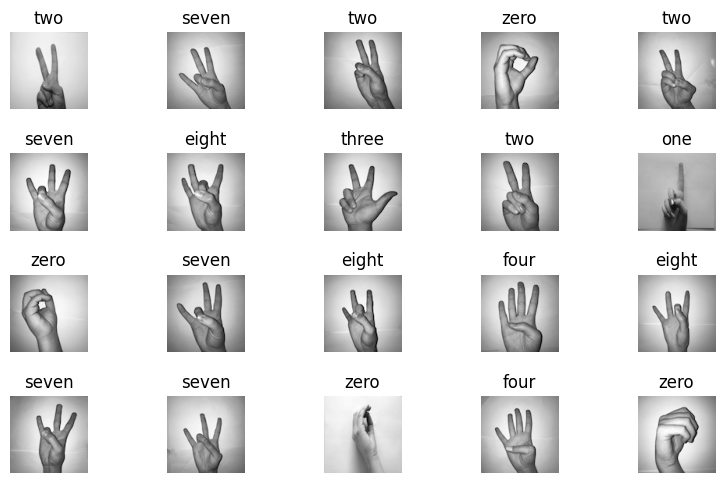

In [8]:
plt.subplots(4, 5, figsize = (8, 5))
plt.tight_layout()
for i in range(0, 20):
    n = np.random.randint(0, x.shape[0])
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.gca().set_title(y[n])
    plt.imshow(x[n], cmap = 'gray')
plt.show()

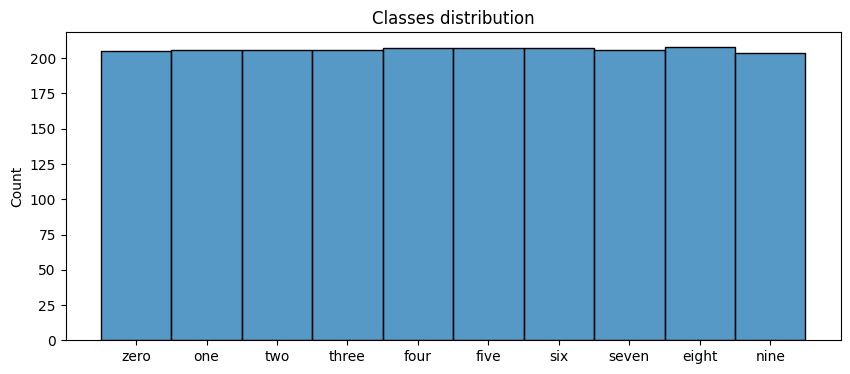

In [9]:
plt.figure(figsize = (10, 4))
plt.title('Classes distribution')
sb.histplot(y, discrete = True)
plt.show()

# Creating augmentation layers

In [11]:
example_x, example_y = make_numpy_dataset('Examples', labels)
np.save(f'{drive_path}/example_signs_x.npy', x)
np.save(f'{drive_path}/example_signs_y.npy', y)
print('Done!')

Done!


In [15]:
example_x = np.reshape(example_x, (example_x.shape[0], example_x.shape[1], example_x.shape[2], 1))
print(example_x.shape)
print(example_y.shape)

(10, 100, 100, 1)
(10,)


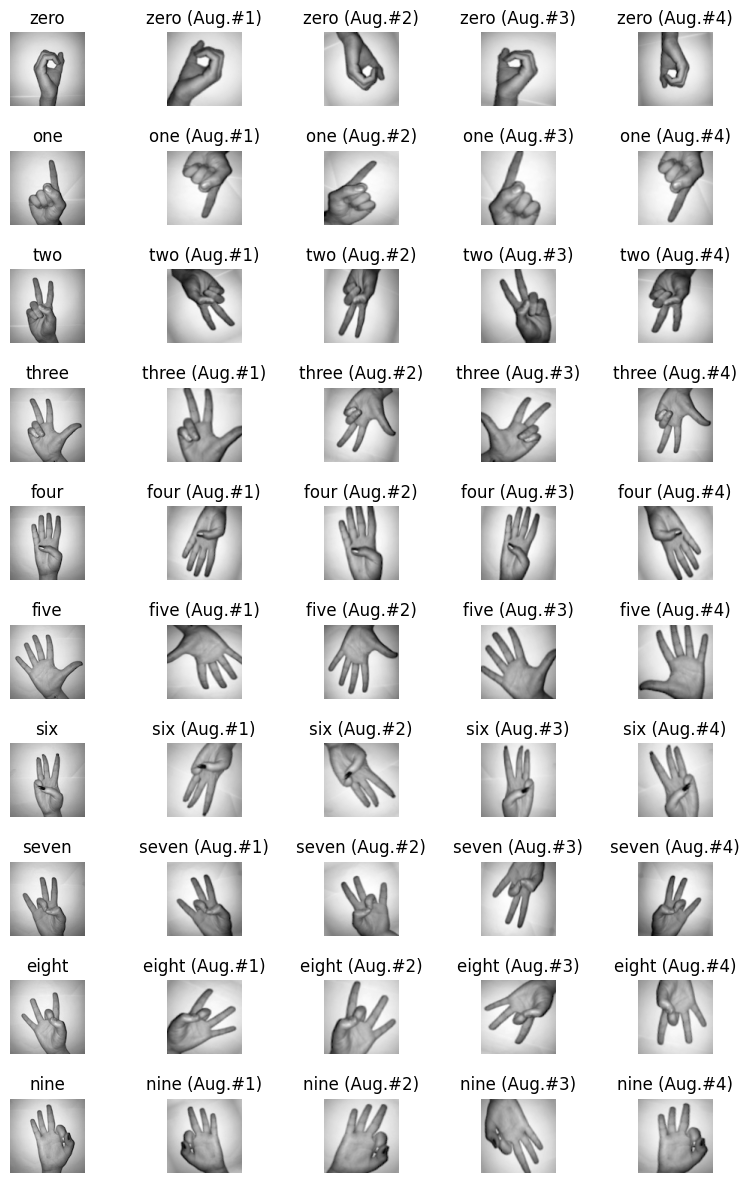

In [106]:
augmentation = Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.1),
    RandomZoom(height_factor = (0.0, -0.3), width_factor = (0.0, -0.3))
])

num_subplot = 0
example_digits_count = example_x.shape[0]
plt.subplots(example_digits_count, 5, figsize = (8, 12))
plt.tight_layout()
for i in range(0, example_digits_count):
    num_subplot += 1
    plt.subplot(example_digits_count, 5, num_subplot)
    plt.axis('off')
    plt.gca().set_title(f'{example_y[i]}')
    plt.imshow(example_x[i], cmap = 'gray')
    for j in range(0, 4):
        num_subplot += 1
        plt.subplot(example_digits_count, 5, num_subplot)
        plt.axis('off')
        plt.gca().set_title(f'{example_y[i]} (Aug.#{j + 1})')
        image = augmentation(example_x[i], training = True).numpy().astype('uint8')
        plt.imshow(image, cmap = 'gray')
plt.show()

# Preprocessing

In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_y = encoder.fit_transform(y)
print(encoder.inverse_transform([0]))
print(encoder.classes_)

['eight']
['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [26]:
encoded_y

array([9, 9, 9, ..., 3, 3, 3])

In [27]:
reshaped_x = np.reshape(x, (x.shape[0], x.shape[1], x.shape[2], 1))
reshaped_x.shape

(2062, 100, 100, 1)

# Data split

## Using train_test_split function...

In [28]:
x_train_, x_test, y_train_, y_test = train_test_split(reshaped_x, encoded_y, test_size = 0.25, random_state = 42, shuffle = True)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_, y_train_, test_size = 0.1, random_state = 42)

print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (1391, 100, 100, 1)
y train: (1391,)

x test: (516, 100, 100, 1)
y test: (516,)

x validation: (155, 100, 100, 1)
y validation: (155,)


In [29]:
np.save(f'{drive_path}/signs_x_train.npy', x_train)
np.save(f'{drive_path}/signs_x_test.npy', x_test)
np.save(f'{drive_path}/signs_x_validation.npy', x_validation)
np.save(f'{drive_path}/signs_y_train.npy', y_train)
np.save(f'{drive_path}/signs_y_test.npy', y_test)
np.save(f'{drive_path}/signs_y_validation.npy', y_validation)
print('Done!')

Done!


## ...Or loading necessary datasets from files

In [30]:
x_train = np.load(f'{drive_path}/signs_x_train.npy')
x_test = np.load(f'{drive_path}/signs_x_test.npy')
x_validation = np.load(f'{drive_path}/signs_x_validation.npy')
y_train = np.load(f'{drive_path}/signs_y_train.npy')
y_test = np.load(f'{drive_path}/signs_y_test.npy')
y_validation = np.load(f'{drive_path}/signs_y_validation.npy')

print(f'x train: {x_train.shape}')
print(f'y train: {y_train.shape}')
print()
print(f'x test: {x_test.shape}')
print(f'y test: {y_test.shape}')
print()
print(f'x validation: {x_validation.shape}')
print(f'y validation: {y_validation.shape}')

x train: (1391, 100, 100, 1)
y train: (1391,)

x test: (516, 100, 100, 1)
y test: (516,)

x validation: (155, 100, 100, 1)
y validation: (155,)


# Encoder for dataset from files

In [31]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels)
print(encoder.inverse_transform([0]))
print(encoder.classes_)

['eight']
['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


# Convolutional neural network for image classification

In [32]:
def show_confusion_matrix(labels_test, labels_predicted, labels = None):
    plt.figure(figsize = (10, 7))
    cm = confusion_matrix(labels_test, labels_predicted)
    if labels != None:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels = labels)
    else:
        sb.heatmap(
            cm,
            annot = True,
            fmt = 'd',
            cbar = False)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

def show_training_history(history, metrics, metric_names, figure_size = (7, 6), last_epoch = None):
    if len(metrics) == 1 and len(metric_names) == 1:
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots()
        metric = metrics[0]
        metric_name = metric_names[0]
        ax.plot(history[metric], color = 'b', label = f'Training {metric_name}')
        if f'val_{metric}' in history:
            ax.plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}')
        if last_epoch is not None:
            ax.axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
        legend = ax.legend(loc = 'best', shadow = True)
        plt.show()
    elif len(metrics) > 1 and len(metrics) == len(metric_names):
        plt.figure(figsize = figure_size)
        fig, ax = plt.subplots(len(metrics), 1)
        for i in range(len(metrics)):
            metric = metrics[i]
            metric_name = metric_names[i]
            ax[i].plot(history[metric], color = 'b', label = f'Training {metric_name}')
            if f'val_{metric}' in history:
                ax[i].plot(history[f'val_{metric}'], color = 'r', label = f'Validation {metric_name}', axes = ax[i])
            if last_epoch is not None:
                ax[i].axvline(x = last_epoch, color = 'g', label = 'Start of fine tuning')
            legend = ax[i].legend(loc = 'best', shadow = True)
        plt.show()
    else:
        raise Exception('Invalid metrics/metric names amount')

In [33]:
img_width = x_train.shape[1]
img_height = x_train.shape[2]
channels = x_train.shape[3]
num_classes = len(encoder.classes_)

print(f'Width: {img_width}')
print(f'Height: {img_height}')
print(f'Channels: {channels}')
print(f'Number of classes: {num_classes}')

Width: 100
Height: 100
Channels: 1
Number of classes: 10


In [127]:
cnn = Sequential([
    # preprocessing
    #Rescaling(scale = 1.0/255.0, input_shape = (img_width, img_height, channels)), # this accuracy is suffering a lot
    Rescaling(scale = 1.0/127.5, offset = -1, input_shape = (img_width, img_height, channels)),

    # augmentation
    #RandomFlip('horizontal_and_vertical'),
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(height_factor = (0.0, -0.3), width_factor = (0.0, -0.3)),

    # convolution
    Conv2D(8, (3, 3), input_shape = (img_width, img_height, channels)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(16, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2)),


    Conv2D(32, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(64, (3, 3)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size = (2, 2)),

    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.15),
    Dense(256, activation = 'relu'),
    Dropout(0.20),
    Dense(128, activation = 'relu'),
    Dropout(0.25),
    Dense(64, activation = 'relu'),
    Dense(num_classes, activation = 'softmax')
])

cnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
input_shape = x_train.shape
cnn.build(input_shape = input_shape)
print(cnn.summary())

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_35 (Rescaling)    (None, 100, 100, 1)       0         
                                                                 
 random_flip_39 (RandomFlip  (None, 100, 100, 1)       0         
 )                                                               
                                                                 
 random_rotation_43 (Random  (None, 100, 100, 1)       0         
 Rotation)                                                       
                                                                 
 random_zoom_47 (RandomZoom  (None, 100, 100, 1)       0         
 )                                                               
                                                                 
 conv2d_130 (Conv2D)         (None, 98, 98, 8)         80        
                                                     

In [128]:
epochs = 50
batch_size = 32
cnn_history = cnn.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_validation, y_validation),
    batch_size = batch_size,
    epochs = epochs)

loss, accuracy = cnn.evaluate(x_test, y_test)

print('---------')
print(f'Accuracy: {accuracy}, loss: {loss}')
print('---------')

Epoch 1/50
44/44 [==============================] - 7s 17ms/step - loss: 2.3076 - accuracy: 0.1603 - val_loss: 2.3107 - val_accuracy: 0.1032
Epoch 2/50
44/44 [==============================] - 0s 11ms/step - loss: 1.8493 - accuracy: 0.3314 - val_loss: 2.3182 - val_accuracy: 0.1097
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 1.4314 - accuracy: 0.4723 - val_loss: 2.5019 - val_accuracy: 0.1097
Epoch 4/50
44/44 [==============================] - 0s 10ms/step - loss: 1.1835 - accuracy: 0.5838 - val_loss: 3.0272 - val_accuracy: 0.1032
Epoch 5/50
44/44 [==============================] - 0s 10ms/step - loss: 0.9905 - accuracy: 0.6628 - val_loss: 2.6531 - val_accuracy: 0.1613
Epoch 6/50
44/44 [==============================] - 0s 10ms/step - loss: 0.8775 - accuracy: 0.6988 - val_loss: 2.2259 - val_accuracy: 0.3032
Epoch 7/50
44/44 [==============================] - 0s 10ms/step - loss: 0.8090 - accuracy: 0.7009 - val_loss: 1.9578 - val_accuracy: 0.4129
Epoch 8/50
44

<Figure size 700x600 with 0 Axes>

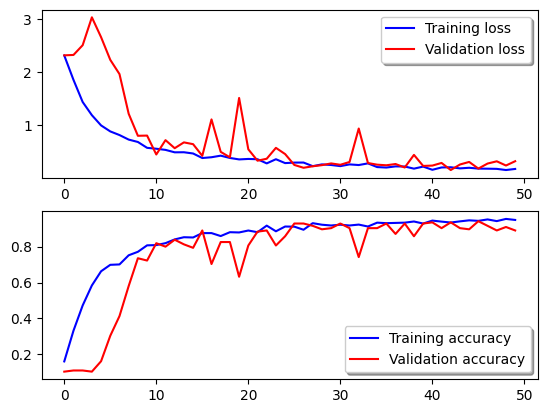

17/17 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       eight       0.85      0.98      0.91        54
        five       1.00      0.87      0.93        45
        four       0.97      0.77      0.86        44
        nine       0.93      0.86      0.90        50
         one       0.92      1.00      0.96        60
       seven       0.90      0.88      0.89        52
         six       0.84      0.94      0.89        50
       three       0.88      0.88      0.88        52
         two       0.90      0.92      0.91        62
        zero       1.00      1.00      1.00        47

    accuracy                           0.91       516
   macro avg       0.92      0.91      0.91       516
weighted avg       0.92      0.91      0.91       516



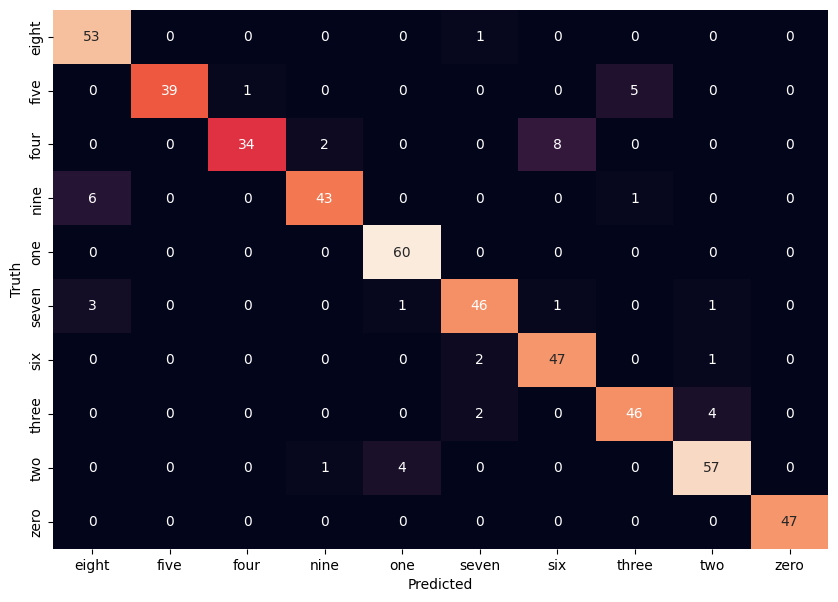

In [129]:
show_training_history(cnn_history.history, metrics = ['loss', 'accuracy'], metric_names = ['loss', 'accuracy'])
y_pred = np.argmax(cnn.predict(x_test), axis = 1)
print(classification_report(
    encoder.inverse_transform(y_test),
    encoder.inverse_transform(y_pred)))
show_confusion_matrix(y_test, y_pred, list(encoder.classes_))

In [130]:
cnn.save(f'{drive_path}/signs.keras')

# Model testing

In [136]:
from PIL import Image
import os

def test_model(model, label_encoder, image_path, image_width, image_height, num_channels):
    test_image = Image.open(image_path)
    test_image_resized = test_image.resize((image_width, image_height))
    monochrome_test_image_reshaped = np.reshape(np.asarray(test_image_resized.convert('L')), (1, image_width, image_height, num_channels))
    inference = model.predict_on_batch(monochrome_test_image_reshaped)
    predicted_value = np.argmax(inference, axis = -1)
    predicted_label = label_encoder.inverse_transform(predicted_value)[0]
    probability = inference[0][predicted_value][0]
    return test_image_resized, predicted_value, predicted_label, inference, probability

def test_model_on_image(model, label_encoder, image_path, image_width, image_height, num_channels):
    image, predicted_value, predicted_label, _, probability = test_model(
        model,
        label_encoder,
        image_path,
        image_width,
        image_height,
        num_channels)
    plt.figure(figsize = (2, 2))
    plt.axis('off')
    plt.gca().set_title(f'{predicted_label} ({probability * 100:.2f}%)')
    plt.imshow(image)
    plt.show()

def test_model_on_dataset(model, label_encoder, dataset_path, labels, image_width, image_height, num_channels):
    y_true = []
    y_pred = []
    for label in labels:
        folder = dataset_path + '/' + label
        for folder_file in os.listdir(folder):
            image_path = folder + '/' + folder_file
            try:
                image, predicted_value, predicted_label, _, probability = test_model(
                    model,
                    label_encoder,
                    image_path,
                    image_width,
                    image_height,
                    num_channels)
                y_true.append(label_encoder.transform([label]))
                y_pred.append(predicted_value)
                plt.figure(figsize = (2, 2))
                plt.axis('off')
                label_name = predicted_label if (predicted_label == label) else f'{predicted_label} [X] - {label}'
                plt.gca().set_title(f'{label_name} ({probability * 100:.2f}%)')
                plt.imshow(image)
                plt.show()
            except Exception as ex:
                print(f'Prediction failed on image "{image_path}": {ex}')
    return y_true, y_pred

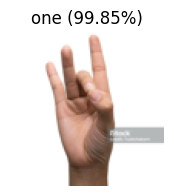

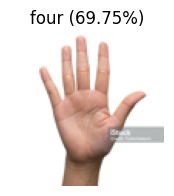

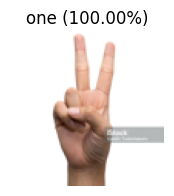

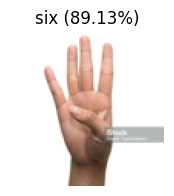

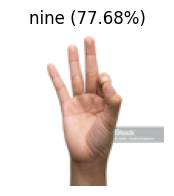

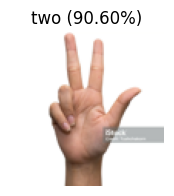

In [140]:
test_model_on_image(cnn, encoder, 'eight.png', 100, 100, 1)
test_model_on_image(cnn, encoder, 'five.png', 100, 100, 1)
test_model_on_image(cnn, encoder, 'two.png', 100, 100, 1)
test_model_on_image(cnn, encoder, 'four.png', 100, 100, 1)
test_model_on_image(cnn, encoder, 'nine.png', 100, 100, 1)
test_model_on_image(cnn, encoder, 'three.png', 100, 100, 1)